# A-gs model and implementation (simulation CO2 and H2O flux)

## Initialize data and model

### Setup and fetch data

In [1]:
# Settings
Username   = 'Beheerder'
years      = range(2008,2019)    #(1997,2021) # Set years to download

In [2]:
import os
datapath = os.path.join('../')
#print('datapath is set to %s'%datapath)

# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install plotly 
# !pip install cufflinks
#!pip install colorspacious
#!pip install seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly.express as px
#import cufflinks as cf
import matplotlib.dates as mdate
import matplotlib.ticker as ticker
from matplotlib import cm
#from colorspacious import cspace_converter
import scipy.stats as stats
#cf.go_offline()
#cf.set_config_file(offline=False, world_readable=True)

from datetime import datetime, timedelta
import sys
sys.path.insert(0, os.path.join(datapath,'PythonScripts'))
from Loobos_Toolbox import dateparse, dateparse_Gapfilled, Read_LoobosEddFinal, Read_LooStor, Read_LoodatGapfill, Read_Loobos_halfhourly, Read_Loobos_meteo, Read_Loobos_soil, Read_Loobos_profile
from Ags_model import runAgs, calc_LE

In [3]:
#these next two lines are to prevent re-loading the data. If you want to re-load data, instead comment them out
if not 'progress' in globals(): progress = list()
if not 'dataloaded' in progress:
  # Read files
    df_EC           = Read_LoobosEddFinal    (years,datapath)
    df_Stor         = Read_LooStor           (years,datapath)
    df_Comb         = Read_LoodatGapfill     (years,datapath)
    df_NEE          = Read_Loobos_halfhourly (years,datapath)
    df_meteo        = Read_Loobos_meteo      (years,datapath)
    df_soil         = Read_Loobos_soil       (years,datapath) 
    df_profile      = Read_Loobos_profile    (years,datapath)
    progress.append('dataloaded')

Loading 2008
Loading 2009
Loading 2010
Loading 2011
Loading 2012
Loading 2013
Loading 2014
Loading 2015
Loading 2016
Loading 2017
Loading 2018
df_EC loaded. Columns in this dataframe:
Index(['Doy', 'Dtime', 'Flx_Tsonic', 'Flx_Lo-H2O', 'Flx_Lo-CO2', 'Qf_Tsonic',
       'Qf_Lo-H2O', 'Qf_Lo-CO2', 'Mea_Windsp', 'Mea_Tsonic', 'Mea_Lo-H2O',
       'Mea_Lo-CO2', 'U-star', 'Z-over-L', 'Wind-Dir', '80PercFlux'],
      dtype='object')
Loading 2008
Loading 2009


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2010
Loading 2011


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2012
Loading 2013


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2014
Loading 2015


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2016
Loading 2017


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2018
df_Stor loaded. Columns in this dataframe:
Index(['Day', 'Time', 'TotalT', 'TotalTflux', 'TotalH2O', 'TotalH2Oflux',
       'TotalCO2', 'TotalCO2flux', 'CO2-2.5m', 'CO2flux-2.5m'],
      dtype='object')
Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009
Loading 2010
Loading 2011
Loading 2012
Loading 2013
Loading 2014
Loading 2015
Loading 2016
Loading 2017
Loading 2018
df_Comb loaded. Columns in this dataframe:
Index(['Year', 'DoY', 'Hour', 'qcNEE', 'NEE', 'LE', 'H', 'Rg', 'Tair', 'Tsoil',
       'rH', 'Ustar', 'VPD', 'NEE_orig', 'NEE_f', 'NEE_fqc', 'NEE_fall',
       'NEE_fall_qc', 'NEE_fnum', 'NEE_fsd', 'NEE_fmeth', 'NEE_fwin',
       'Rg_orig', 'Rg_f', 'Rg_fqc', 'Rg_fall', 'Rg_fall_qc', 'Rg_fnum',
       'Rg_fsd', 'Rg_fmeth', 'Rg_fwin', 'H_orig', 'H_f', 'H_fqc', 'H_fall',
       'H_fall_qc', 'H_fnum', 'H_fsd', 'H_fmeth', 'H_fwin', 'LE_orig', 'LE_f',
       'LE_fqc', 'LE_fall', 'LE_fall_qc', 'LE_fnum', 'LE_fsd', 'LE_fmeth',
       'LE_fwin', 'Tair_orig', 'Tair_f', 'Tair_fqc', 'Tair_fall',
       'Tair_fall_qc', 'Tair_fnum', 'Tair_fsd', 'Tair_fmeth', 'Tair_fwin',
       'PotRad', 'FP_NEEnight', 'FP_Temp', 'E_0', 'R_ref', 'Reco', 'GPP_f',
       'GPP_fqc'],
      dtype='object')
Loading 2008
Loading 2009


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2010


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2011
Loading 2012


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2013
Loading 2014


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2015
Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2017
Loading 2018


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Done
df_NEE loaded. Columns in this dataframe:
Index(['NEE_f', 'H_f', 'LE_f', 'Reco_f', 'GPP_f'], dtype='object')
Loading 2008
Loading 2009


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2010
Loading 2011


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2012
Loading 2013


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2014
Loading 2015


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2016
Loading 2017


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2018


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_meteo loaded. Columns in this dataframe:
Index(['Daynumber', 'Time', 'S(i)', 'S(o)', 'L(i)', 'L(o)', 'L(i)corr',
       'L(o)corr', 'R(net)', 'PARrefl', 'PAR', 'PARdiff', 'G1', '-q',
       'Te(vaisal)', 'Te-L(i)', 'Te-L(o)', '-u(z)', '-u(dir)', 'H2Olic',
       'CO2lic', 'Vbatt', 'CR10temp', 'P(mast)', 'P(guter)', 'P(field)',
       'SD S(i)', 'SD L(i)', 'SD q', 'SD Te(vaisal)', 'SD u(z)'],
      dtype='object')
Loading ../\Soilmoist\Final\Loosoifinal08.csv...
Loading ../\Soilmoist\Final\Loosoifinal09.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal10.csv...
Loading ../\Soilmoist\Final\Loosoifinal11.csv...
Loading ../\Soilmoist\Final\Loosoifinal12.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future vers

Loading ../\Soilmoist\Final\Loosoifinal13.csv...
Loading ../\Soilmoist\Final\Loosoifinal14.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal15.csv...
Loading ../\Soilmoist\Final\Loosoifinal16.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal17.csv...
Loading ../\Soilmoist\Final\Loosoifinal18.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_soil loaded. Columns in this dataframe:
Index(['Daynumber', 'Time', 'SM-Lit', 'SM-003', 'SM-020', 'SM-050', 'SM-100',
       'ST-Lit', 'ST-003', 'ST-020', 'ST-050', 'ST-100', 'T-bole', 'Temp200',
       'Temp201', 'Temp202', 'Temp203', 'Temp204', 'Temp205', 'Temp206',
       'Temp207'],
      dtype='object')
Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009
Loading 2010


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2011
Loading 2012


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2013
Loading 2014


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2015
Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2017
Loading 2018
df_profile loaded. Columns in this dataframe:
Index(['Daynumber', 'Time', 'VaiVPtop', 'VaiVPmid', 'Vtemptop', 'Vtempmid',
       'VecWStop', 'VecWSmid', 'Pressure', 'H2Olevel1', 'H2Olevel2',
       'H2Olevel3', 'H2Olevel4', 'H2Olevel5', 'CO2level1', 'CO2level2',
       'CO2level3', 'CO2level4', 'CO2level5', 'H2Ocal', 'CO2cal'],
      dtype='object')


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


In [4]:
# Make filter for GPP orginial data and not gapfilled
#General filters
I = ((df_Comb['GPP_fqc']==0)&(df_meteo['PAR']>0))
#t = df_profile.index                                          
#time = (t < np.datetime64('2013-05-08')) | (t > np.datetime64('2013-06-01'))

# Filter for CO2 data
CO2 = (df_profile['CO2level1'] > 300)

# Filter for L(o)corr data
Locorr= (df_meteo['L(o)corr']>0) 

# Filter for VPD data
VPD = (df_Comb['VPD']>=0)

# Filter for U-star
Ustar = (df_EC['U-star']>=0)

# Combine all filters
filter = I & CO2 & Locorr & VPD & Ustar

#Column 'CO2' is input from df_profile
#df_profile_CO2 = df_profile[CO2]
#df_profile_filter = df_profile_CO2[I]
df_profile_filter = df_profile[filter]

#Column 'L(o)corr' and 'PAR' are inputs from df_meteo
#df_meteo_CO2 = df_meteo[CO2]
#df_meteo_filter = df_meteo_CO2[I]
df_meteo_filter = df_meteo[filter]

#Columns 'VPD' and 'Tair' are inputs from df_Comb
#df_Comb_CO2 = df_Comb[CO2]
#df_Comb_filter = df_Comb_CO2[I]
df_Comb_filter = df_Comb[filter]

# Columns 'Mea_Windsp' and 'U-star' are inputs from df_EC
#df_EC_CO2 = df_EC[CO2]
#df_EC_filter = df_EC_CO2[I]
df_EC_filter = df_EC[filter]

### Run A-gs model

In [5]:
# Run A-gs model

an_final,an_umol,rs, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=0.8)

<Axes: title={'center': 'Monthly average GPP model output'}, ylabel='umolm-2s-1'>

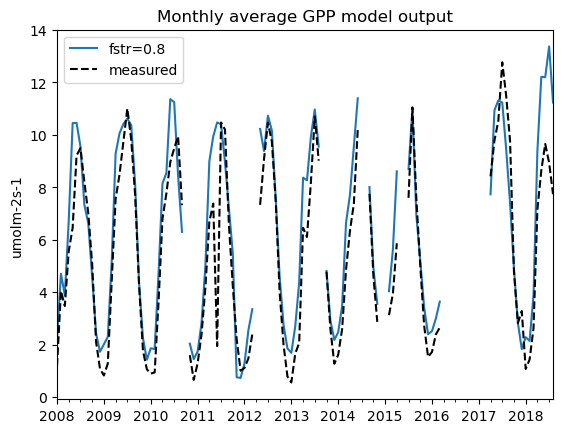

In [6]:
GPP_sim=an_umol.resample("M").mean()
GPP_sim.plot(label="fstr=0.8",legend='yes',title="Monthly average GPP model output",ylabel="umolm-2s-1")
GPP_meas=df_Comb_filter['GPP_f'].resample("M").mean()
GPP_meas.plot(c='black', linestyle='dashed',label='measured',legend='yes')

In [11]:
#rs.resample("M").mean().plot()

## Calcuate ET

### Assemble dataframe 'df_ET' that will hold output and fill with inputs

In [7]:
def init_ETframe(rs_series):
    df_ET = pd.concat([df_meteo['L(o)'],df_meteo['Te-L(o)'],df_profile['Pressure'],df_Comb['VPD'],df_Comb['rH'],df_meteo['P(mast)']],axis=1,sort=False)
    #convert Pressure from hPa to kPa 
    df_ET['p_kPa']=df_ET['Pressure']/10
    df_ET['VPD_adj']=df_ET['VPD'].loc[df_ET['VPD']>0] #some outlier values for VPD are negative, remove from dataset
    df_ET['VPD_adj']=df_ET['VPD_adj']/10  # VPD from df_Comb is in hPa, I need kPa, so hPa/10 = kPa
    df_ET['rs']=rs_series.to_frame(name="rs")
    df_ET['ra']=ra.to_frame(name="ra")
    return df_ET

In [8]:
df_ET=init_ETframe(rs)

In [9]:
df_ET=calc_LE(df_ET)

In [10]:
df_ET_meas=df_Comb_filter.copy()
df_ET_meas=df_ET_meas.loc[df_ET_meas['LE']>=0]
df_ET_meas=df_ET_meas.resample("M").mean()
#df_ET_meas['LE'].plot()

<Axes: title={'center': 'Monthly average LE model output'}, ylabel='Wm-2'>

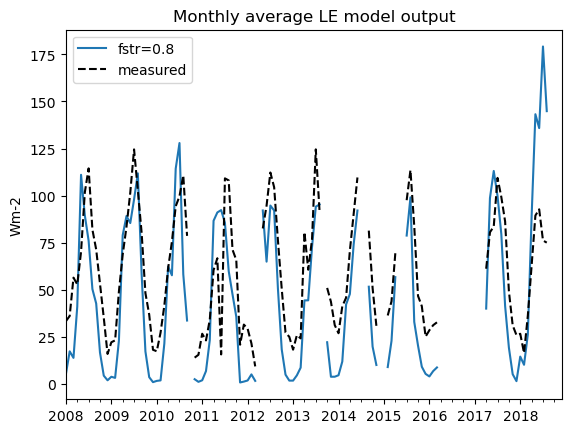

In [11]:
df_ET['ET_VPD'].resample('M').mean().plot(label="fstr=0.8",legend='yes',title="Monthly average LE model output",ylabel="Wm-2")
df_ET_meas['LE'].resample('M').mean().plot(c='black', linestyle='dashed',label='measured',legend='yes')

### calculate ET

In [ ]:
#df_ET_10['ET_VPD'].resample("M").mean().plot()
#measured_data=df_Comb['LE'].loc[df_Comb['LE']>0].resample('M').mean()
#measured_data.plot(legend="measured")

#I_filter = ((df_Comb['GPP_fqc']==0)&(df_Comb['LE']>0)&(df_Comb['VPD'] > 0))

#VPD_filter = (df_Comb['VPD'] > 0)
#df_test=df_Comb[I_filter]

#df_test['LE'].resample('M').mean().plot()
#df_Comb['LE'].resample('M').mean().plot()

### CO2 flux

R2:  0.8093654477013645
slope, intercept: 0.9502078391356075 0.2195097088940292


Text(0, 0.5, 'Hour')

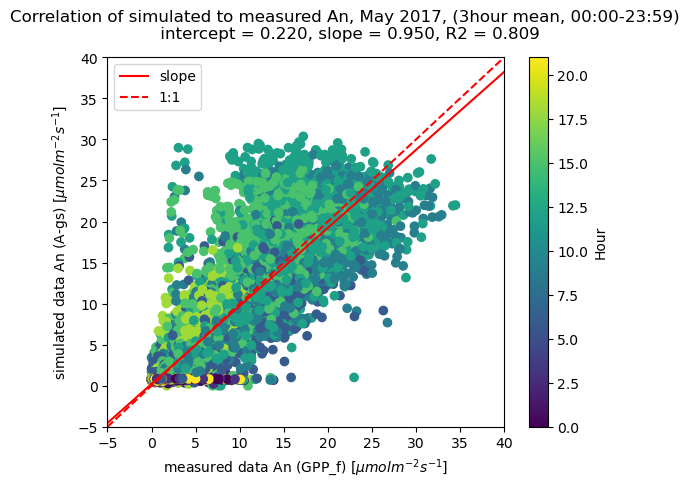

In [14]:
start='2008-05-01 00:00'
end='2018-09-30 00:00'
sim_data=an_umol.loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
measured_data=df_Comb['GPP_f'].loc[df_Comb['GPP_f']>0].loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
measured_data=measured_data.dropna()

df_tmp = pd.DataFrame()
df_tmp['sim_data']=sim_data

df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['GPP_f'], df_tmp['sim_data'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('R2: ',r_value**2)
print('slope, intercept:', slope, intercept)

fig,ax = plt.subplots()
p1=ax.scatter(df_tmp['GPP_f'],df_tmp['sim_data'],c=df_tmp.index.hour,cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
ax.set_ylim(-5,40)
ax.set_xlim(-5,40)
ax.set_xlabel(r'measured data An (GPP_f) [$\mu molm^{-2}s^{-1}$]')
ax.set_ylabel(r'simulated data An (A-gs) [$\mu molm^{-2}s^{-1}$]')
fig.suptitle('Correlation of simulated to measured An, May 2017, (3hour mean, 00:00-23:59) \n intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
ax.legend(loc='upper left')
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Hour')

### H2O flux

In [13]:
# Add in precipitation last 3h and 24 hour values so it can be used for filtering
df_ET['last3day_prec']=df_ET['P(mast)'].rolling('72H').sum()

R2:  0.5024333844142947
slope, intercept: 1.2584009379338725 3.224081110739675


Text(0, 0.5, 'Month')

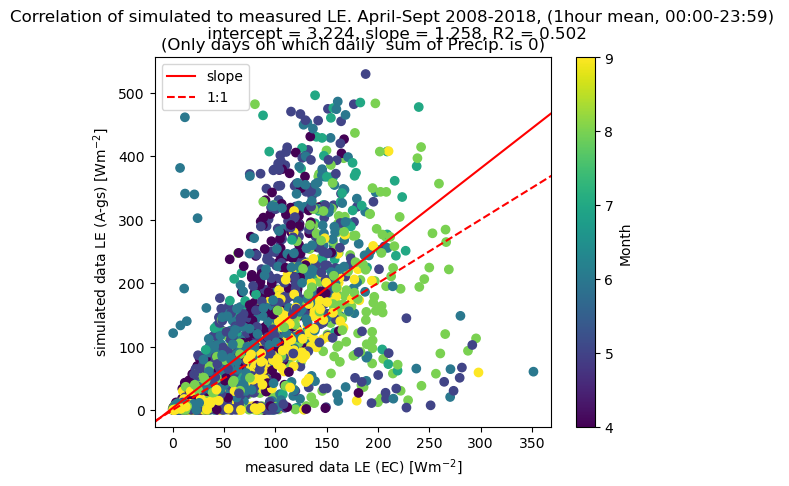

In [17]:
#re-draw better correlation plot (longer dataset)
#start='2017-04-01 00:00'
#end='2017-07-30 00:00'
start='2008-05-01 00:00'
end='2018-09-30 00:00'
months=[4,5,6,7,8,9]

#new filter
sim_data = df_ET.loc[start:end,('ET_VPD','last3day_prec','T_sfc_C')]
sim_data = sim_data.loc[sim_data['last3day_prec']==0]
#sim_data = sim_data.loc[sim_data.index.month>=4]
#sim_data = sim_data.loc[sim_data.index.month<=9]
sim_data = sim_data.loc[sim_data.index.month.isin(months)]
sim_data= sim_data.resample('3H').mean()#.between_time("9:00", "15:00")
sim_data=sim_data.dropna()

measured_data=df_Comb['LE'].loc[df_Comb['LE']>0].loc[start:end].resample('3H').mean()#.between_time("9:00", "15:00")
measured_data = measured_data.loc[measured_data.index.month.isin(months)]
#measured_data = measured_data.loc[measured_data.index.month<=9]
measured_data=measured_data.dropna()

df_tmp=sim_data.copy()
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['LE'], df_tmp['ET_VPD'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('R2: ',r_value**2)
print('slope, intercept:', slope, intercept)

fig,ax = plt.subplots()
p1=ax.scatter(df_tmp['LE'],df_tmp['ET_VPD'],c=df_tmp.index.month,cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
#ax.set_ylim(-10,300)
#ax.set_xlim(-10,300)
ax.set_xlabel(r'measured data LE (EC) [Wm$^{-2}$]')
ax.set_ylabel(r'simulated data LE (A-gs) [Wm$^{-2}$]')
fig.suptitle('Correlation of simulated to measured LE. April-Sept 2008-2018, (1hour mean, 00:00-23:59) \n intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
ax.set_title('(Only days on which daily  sum of Precip. is 0)')
ax.legend(loc='upper left')
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Month')

## fstr analysis

## plot timeseries

In [14]:
1#re-draw better correlation plot (longer dataset)
#start='2017-04-01 00:00'
#end='2017-07-30 00:00'
start='2008-05-01 00:00'
end='2018-09-30 00:00'
months=[6,7,8]

#new filter
sim_data = df_ET.loc[start:end,('ET_VPD','last3day_prec')]
sim_data = sim_data.loc[sim_data['last3day_prec']==0]
sim_data = sim_data.loc[sim_data.index.month.isin(months)]
sim_data= sim_data.resample('3H').mean()#.between_time("9:00", "15:00")
sim_data=sim_data.dropna()

measured_data=df_Comb['LE'].loc[df_Comb['LE']>0].loc[start:end].resample('3H').mean()#.between_time("9:00", "15:00")
measured_data = measured_data.loc[measured_data.index.month.isin(months)]
measured_data=measured_data.dropna()

df_tmp=sim_data.copy()
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)


## extract LE max

<Axes: >

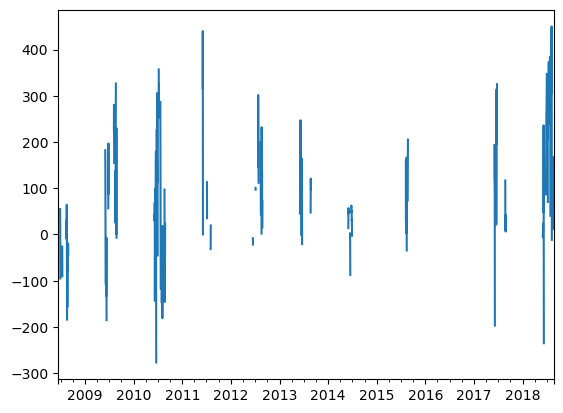

In [15]:
df_max=pd.DataFrame()

df_max['ET_max']=df_tmp['ET_VPD'].resample('1D').max()
df_max['LE_max']=df_tmp['LE'].resample('1D').max()

df_max['maxdiff_ET-LE']=df_max['ET_max']-df_max['LE_max']

df_max['maxdiff_ET-LE'].plot()

#problem: I can't get df_max['ET_idx']=df_tmp['ET_VPD'].resample('1D').idxmax() to work. abandon for now


R2:  0.1448064550720663
slope, intercept: 0.8263272311306321 90.08806713514394


Text(0, 0.5, 'Month')

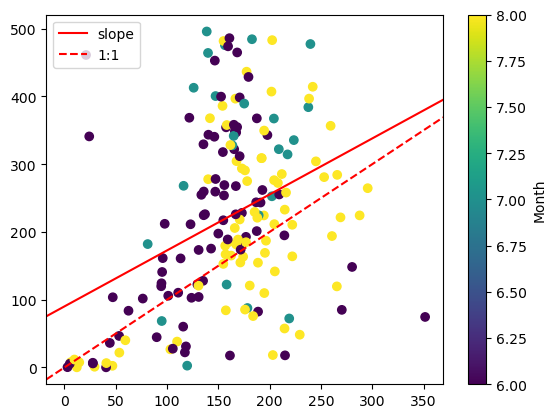

In [71]:
#re-draw better correlation plot (longer dataset)
#start='2017-04-01 00:00'
#end='2017-07-30 00:00'
start='2008-05-01 00:00'
end='2018-09-30 00:00'
months=[4,5,6,7,8]

#new filter
sim_data = pd.DataFrame(df_max['ET_max'])
#sim_data = sim_data.loc[sim_data.index.month.isin(months)]
sim_data=sim_data.dropna()

measured_data=pd.DataFrame(df_max['LE_max'])
#measured_data = measured_data.loc[measured_data.index.month.isin(months)]
measured_data=measured_data.dropna()

df_tmp=sim_data.copy()
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['LE_max'], df_tmp['ET_max'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('R2: ',r_value**2)
print('slope, intercept:', slope, intercept)

fig,ax = plt.subplots()
p1=ax.scatter(df_tmp['LE_max'],df_tmp['ET_max'],c=df_tmp.index.month,cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
#ax.set_ylim(-10,300)
#ax.set_xlim(-10,300)
#ax.set_xlabel(r'measured data LE (EC) [Wm$^{-2}$]')
#ax.set_ylabel(r'simulated data LE (A-gs) [Wm$^{-2}$]')
#fig.suptitle('Correlation of simulated to measured LE. April-Sept 2008-2018, (1hour mean, 00:00-23:59) \n intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
#ax.set_title('(Only days on which daily  sum of Precip. is 0)')
ax.legend(loc='upper left')
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Month')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Month')

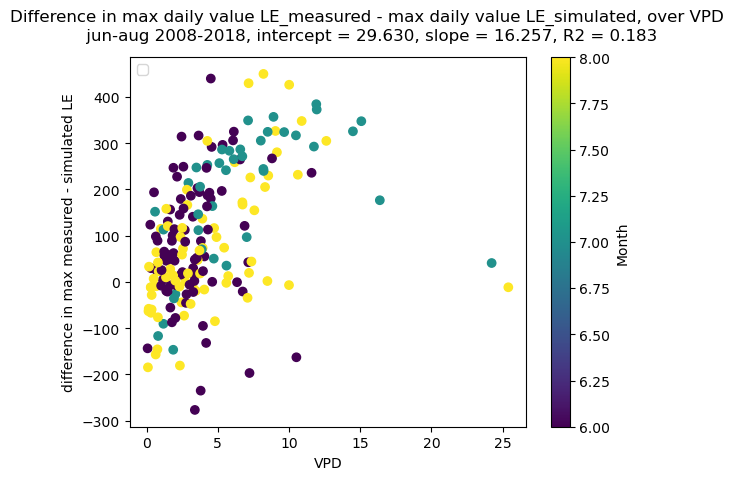

In [24]:
#re-draw better correlation plot (longer dataset)
#start='2017-04-01 00:00'
#end='2017-07-30 00:00'
start='2008-05-01 00:00'
end='2018-09-30 00:00'
months=[4,5,6,7,8]

#new filter
sim_data = pd.DataFrame(df_max['maxdiff_ET-LE'])
#sim_data = sim_data.loc[sim_data.index.month.isin(months)]
sim_data=sim_data.dropna()

measured_data=pd.DataFrame(df_Comb_filter['VPD'])
#measured_data = measured_data.loc[measured_data.index.month.isin(months)]
measured_data=measured_data.dropna()

df_tmp=sim_data.copy()
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

#slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['VPD'], df_tmp['maxdiff_ET-LE'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
#print('R2: ',r_value**2)
#print('slope, intercept:', slope, intercept)

fig,ax = plt.subplots()
p1=ax.scatter(df_tmp['VPD'],df_tmp['maxdiff_ET-LE'],c=df_tmp.index.month,cmap='viridis') #scatter(x,y)
#ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
#ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
#ax.set_ylim(-10,300)
#ax.set_xlim(-10,300)
ax.set_xlabel(r'VPD')
ax.set_ylabel(r'difference in max measured - simulated LE')
fig.suptitle('Difference in max daily value LE_measured - max daily value LE_simulated, over VPD \n jun-aug 2008-2018, intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
#ax.set_title('(Only days on which daily  sum of Precip. is 0)')
ax.legend(loc='upper left')
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Month')

In [77]:
gs=1/rs

<Axes: >

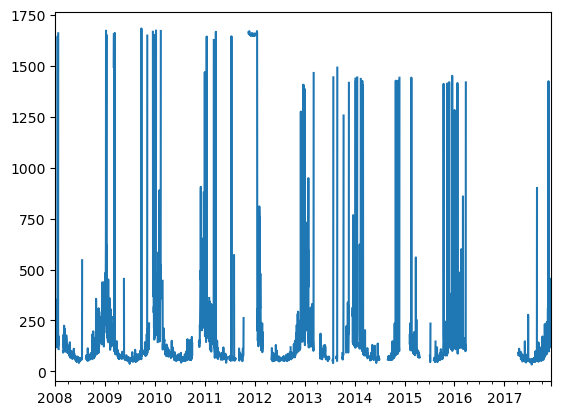

In [91]:
df_gs=pd.DataFrame()
df_gs['rs']=rs
df_gs['gs']=1/rs
df_gsmax=pd.DataFrame()
df_gsmax['gs_max']=df_gs['gs'].resample('1D').max()
df_gsmax['rs_min']=df_gs['rs'].resample('1D').min()
df_gsmax['rs_min'].plot()

<Axes: >

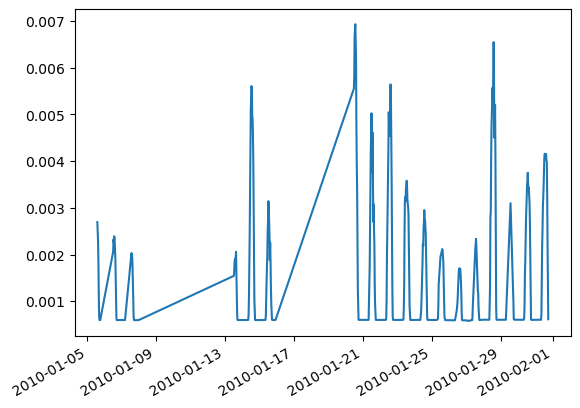

In [88]:
df_gs['gs'].loc['2010-01-01 00:00':'2010-02-01 00:00'].plot()

<Axes: >

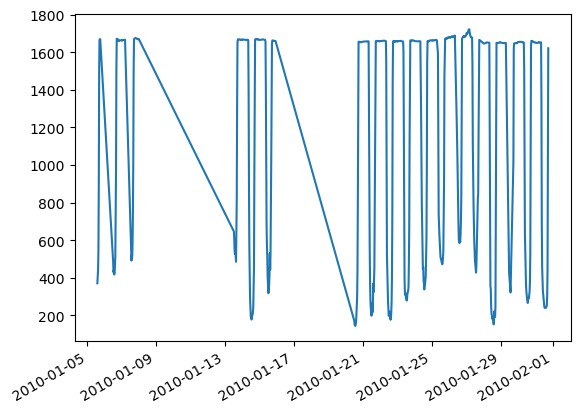

In [89]:
df_gs['rs'].loc['2010-01-01 00:00':'2010-02-01 00:00'].plot()

R2:  0.0002674562427910583
slope, intercept: 2.934534293350012e-07 0.015861612956951977


Text(0, 0.5, 'Month')

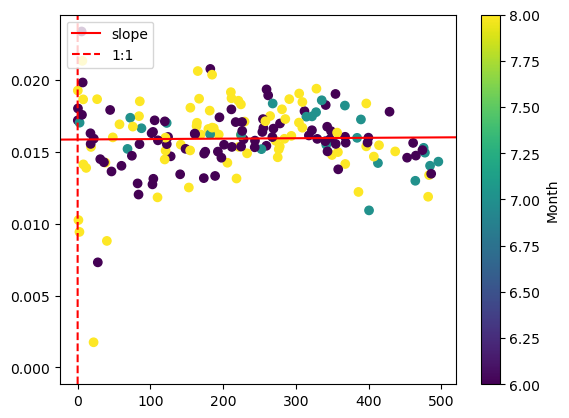

In [94]:
#new correlation for fstr
#start='2017-04-01 00:00'
#end='2017-07-30 00:00'
start='2008-05-01 00:00'
end='2018-09-30 00:00'
months=[4,5,6,7,8]

#new filter
sim_data = pd.DataFrame(df_max['ET_max'])
#sim_data = sim_data.loc[sim_data.index.month.isin(months)]
sim_data=sim_data.dropna()

measured_data=pd.DataFrame(df_gsmax['gs_max'])
#measured_data = measured_data.loc[measured_data.index.month.isin(months)]
measured_data=measured_data.dropna()

df_tmp=sim_data.copy()
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['ET_max'], df_tmp['gs_max'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('R2: ',r_value**2)
print('slope, intercept:', slope, intercept)

fig,ax = plt.subplots()
p1=ax.scatter(df_tmp['ET_max'],df_tmp['gs_max'],c=df_tmp.index.month,cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
#ax.set_ylim(-10,300)
#ax.set_xlim(-10,300)
#ax.set_xlabel(r'measured data LE (EC) [Wm$^{-2}$]')
#ax.set_ylabel(r'simulated data LE (A-gs) [Wm$^{-2}$]')
#fig.suptitle('Correlation of simulated to measured LE. April-Sept 2008-2018, (1hour mean, 00:00-23:59) \n intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
#ax.set_title('(Only days on which daily  sum of Precip. is 0)')
ax.legend(loc='upper left')
cbar=plt.colorbar(p1,ax=ax) 
cbar.ax.set_ylabel('Month')

In [ ]:
#re-draw better correlation plot (longer dataset)
#start='2017-04-01 00:00'
#end='2017-07-30 00:00'
start='2008-05-01 00:00'
end='2018-09-30 00:00'
months=[4,5,6,7,8,9]
3
#new filter
sim_data = df_ET.loc[start:end,('ET_VPD','last3day_prec','T_sfc_C')]
sim_data = sim_data.loc[sim_data['last3day_prec']==0]
#sim_data = sim_data.loc[sim_data.index.month>=4]
#sim_data = sim_data.loc[sim_data.index.month<=9]
sim_data = sim_data.loc[sim_data.index.month.isin(months)]
sim_data= sim_data.resample('3H').mean()#.between_time("9:00", "15:00")
sim_data=sim_data.dropna()

measured_data=df_Comb['LE'].loc[df_Comb['LE']>0].loc[start:end].resample('3H').mean()#.between_time("9:00", "15:00")
measured_data = measured_data.loc[measured_data.index.month.isin(months)]
#measured_data = measured_data.loc[measured_data.index.month<=9]
measured_data=measured_data.dropna()

df_tmp=sim_data.copy()
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['LE'], df_tmp['ET_VPD'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('R2: ',r_value**2)
print('slope, intercept:', slope, intercept)

fig,ax = plt.subplots()
p1=ax.scatter(df_tmp['LE'],df_tmp['ET_VPD'],c=df_tmp.index.month,cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
#ax.set_ylim(-10,300)
#ax.set_xlim(-10,300)
ax.set_xlabel(r'measured data LE (EC) [Wm$^{-2}$]')
ax.set_ylabel(r'simulated data LE (A-gs) [Wm$^{-2}$]')
fig.suptitle('Correlation of simulated to measured LE. April-Sept 2008-2018, (1hour mean, 00:00-23:59) \n intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
ax.set_title('(Only days on which daily  sum of Precip. is 0)')
ax.legend(loc='upper left')
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Month')

## extract calc diff gpp max and just regular diff

## plot diff_gpp max 

## hourly averages section (hour as bins) (TODO: can I prove that in general the shape of the curve is consistent ie. I only need max?)

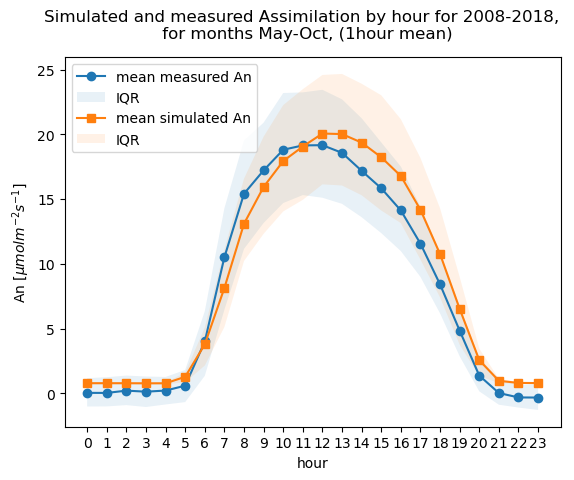

In [68]:
#draw binned An
#start='2017-04-01 00:00'
#end='2017-08-30 00:00'
start='2008-04-01 00:00'
end='2018-08-30 00:00'

sim_data=an_umol.loc[an_umol>0].loc[start:end].resample('1H').mean()#.between_time("11:00", "18:00")
sim_data = sim_data.loc[(sim_data.index.month>=5) & (sim_data.index.month<=8)]
sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
measured_data=df_Comb['GPP_f'].loc[start:end].resample('1H').mean()#.between_time("11:00", "18:00")
measured_data=measured_data.dropna()

#new filter
#sim_data = df_ET_1.loc[start:end,('ET_VPD2','last24h_prec')]
#sim_data = sim_data.loc[sim_data['last24h_prec']<=0.5]

#df_tmp = pd.DataFrame()
df_tmp=pd.DataFrame(sim_data)
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

#slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['GPP_f'], df_tmp['sim_data'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
#print('R2: ',r_value**2)
#print('slope, intercept:', slope, intercept)

hours_list=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

d={}
d['meas_avg'] = [df_tmp.loc[df_tmp.index.hour==i,'GPP_f'].mean() for i in hours_list]
d['meas_q1'] = [df_tmp.loc[df_tmp.index.hour==i,'GPP_f'].quantile(q=0.25) for i in hours_list]
d['meas_q3'] = [df_tmp.loc[df_tmp.index.hour==i,'GPP_f'].quantile(q=0.75) for i in hours_list]
d['sim_avg'] = [df_tmp.loc[df_tmp.index.hour==i,0].mean() for i in hours_list]
d['sim_q1'] = [df_tmp.loc[df_tmp.index.hour==i,0].quantile(q=0.25) for i in hours_list]
d['sim_q3'] = [df_tmp.loc[df_tmp.index.hour==i,0].quantile(q=0.75) for i in hours_list]

df_avg=pd.DataFrame(d)

fig,ax = plt.subplots()
p1=ax.plot(df_avg['meas_avg'],marker='o',label='mean measured An')
ax.fill_between(hours_list,df_avg['meas_q1'],df_avg['meas_q3'],alpha=0.1,label='IQR')
p2=ax.plot(df_avg['sim_avg'],marker='s',label='mean simulated An')
ax.fill_between(hours_list,df_avg['sim_q1'],df_avg['sim_q3'],alpha=0.1,label='IQR')

#ax.set_ylim(-5,40)
#ax.set_xlim(-5,40)
plt.xticks(hours_list) 
ax.set_xlabel('hour')
ax.set_ylabel(r'An [$\mu molm^{-2}s^{-1}$]')
fig.suptitle('Simulated and measured Assimilation by hour for 2008-2018, \n for months May-Oct, (1hour mean)')
ax.legend(loc='upper left')


4002


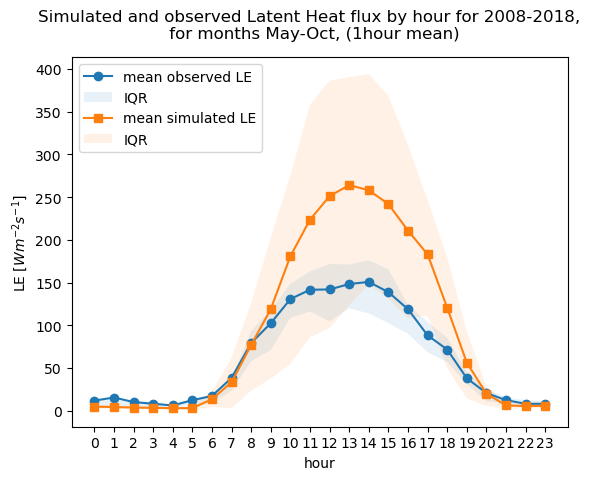

In [29]:
#draw binned LE
start='2008-04-01 00:00'
end='2008-08-30 00:00'

sim_data = df_ET.loc[start:end,('ET_VPD','last3day_prec')]
sim_data = sim_data.loc[(sim_data.index.month>=5) & (sim_data.index.month<=8)]
sim_data = sim_data.loc[sim_data['last3day_prec']==0.0]
print(sim_data.size)
sim_data=sim_data.resample('1H').mean()
sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
measured_data=df_Comb_filter.loc[start:end,'LE']#.resample('1H').mean()#.between_time("11:00", "18:00")
measured_data=measured_data.loc[measured_data>0]
measured_data=measured_data.resample('1H').mean()
measured_data=measured_data.dropna()

#df_tmp = pd.DataFrame()
df_tmp=pd.DataFrame(sim_data)
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

hours_list=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

d={}
d['meas_avg'] = [df_tmp.loc[df_tmp.index.hour==i,'LE'].mean() for i in hours_list]
d['meas_q1'] = [df_tmp.loc[df_tmp.index.hour==i,'LE'].quantile(q=0.25) for i in hours_list]
d['meas_q3'] = [df_tmp.loc[df_tmp.index.hour==i,'LE'].quantile(q=0.75) for i in hours_list]
d['sim_avg'] = [df_tmp.loc[df_tmp.index.hour==i,'ET_VPD'].mean() for i in hours_list]
d['sim_q1'] = [df_tmp.loc[df_tmp.index.hour==i,'ET_VPD'].quantile(q=0.25) for i in hours_list]
d['sim_q3'] = [df_tmp.loc[df_tmp.index.hour==i,'ET_VPD'].quantile(q=0.75) for i in hours_list]

df_avg=pd.DataFrame(d)

fig,ax = plt.subplots()
p1=ax.plot(df_avg['meas_avg'],marker='o',label='mean observed LE')
ax.fill_between(hours_list,df_avg['meas_q1'],df_avg['meas_q3'],alpha=0.1,label='IQR')
p2=ax.plot(df_avg['sim_avg'],marker='s',label='mean simulated LE')
ax.fill_between(hours_list,df_avg['sim_q1'],df_avg['sim_q3'],alpha=0.1,label='IQR')

#ax.set_ylim(-5,40)
#ax.set_xlim(-5,40)
plt.xticks(hours_list) 
ax.set_xlabel('hour')
ax.set_ylabel(r'LE [$Wm^{-2}s^{-1}$]')
fig.suptitle('Simulated and observed Latent Heat flux by hour for 2008-2018, \n for months May-Oct, (1hour mean)')
ax.legend(loc='upper left')


36096


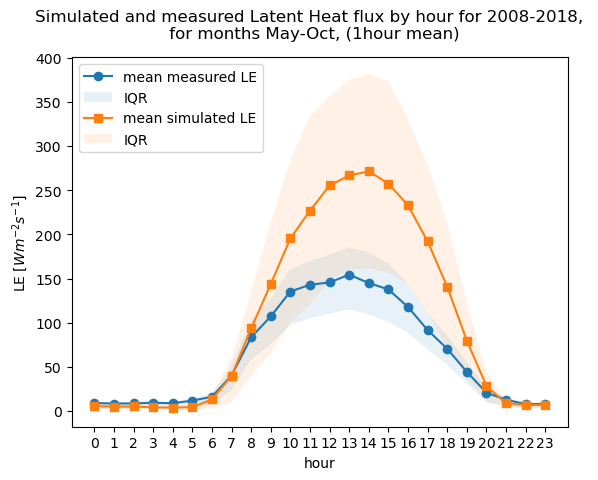

In [25]:
#draw binned LE
start='2008-04-01 00:00'
end='2018-08-30 00:00'

sim_data = df_ET.loc[start:end,('ET_VPD','last3day_prec')]
sim_data = sim_data.loc[(sim_data.index.month>=5) & (sim_data.index.month<=8)]
sim_data = sim_data.loc[sim_data['last3day_prec']==0.0]
print(sim_data.size)
sim_data=sim_data.resample('1H').mean()
sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
measured_data=df_Comb_filter.loc[start:end,'LE']#.resample('1H').mean()#.between_time("11:00", "18:00")
measured_data=measured_data.loc[measured_data>0]
measured_data=measured_data.resample('1H').mean()
measured_data=measured_data.dropna()

#df_tmp = pd.DataFrame()
df_tmp=pd.DataFrame(sim_data)
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

hours_list=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

d={}
d['meas_avg'] = [df_tmp.loc[df_tmp.index.hour==i,'LE'].mean() for i in hours_list]
d['meas_q1'] = [df_tmp.loc[df_tmp.index.hour==i,'LE'].quantile(q=0.25) for i in hours_list]
d['meas_q3'] = [df_tmp.loc[df_tmp.index.hour==i,'LE'].quantile(q=0.75) for i in hours_list]
d['sim_avg'] = [df_tmp.loc[df_tmp.index.hour==i,'ET_VPD'].mean() for i in hours_list]
d['sim_q1'] = [df_tmp.loc[df_tmp.index.hour==i,'ET_VPD'].quantile(q=0.25) for i in hours_list]
d['sim_q3'] = [df_tmp.loc[df_tmp.index.hour==i,'ET_VPD'].quantile(q=0.75) for i in hours_list]

df_avg=pd.DataFrame(d)

fig,ax = plt.subplots()
p1=ax.plot(df_avg['meas_avg'],marker='o',label='mean measured LE')
ax.fill_between(hours_list,df_avg['meas_q1'],df_avg['meas_q3'],alpha=0.1,label='IQR')
p2=ax.plot(df_avg['sim_avg'],marker='s',label='mean simulated LE')
ax.fill_between(hours_list,df_avg['sim_q1'],df_avg['sim_q3'],alpha=0.1,label='IQR')

#ax.set_ylim(-5,40)
#ax.set_xlim(-5,40)
plt.xticks(hours_list) 
ax.set_xlabel('hour')
ax.set_ylabel(r'LE [$Wm^{-2}s^{-1}$]')
fig.suptitle('Simulated and measured Latent Heat flux by hour for 2008-2018, \n for months May-Oct, (1hour mean)')
ax.legend(loc='upper left')

## fstr analysis

### diff between LE sim and Calc

In [92]:
#d['LE-ET_VPD', 'ET_VPD-LE', 'meas_avg', 'meas_q1', 'meas_q3']
d['LE-ET_VPD']

dict_keys(['LE-ET_VPD', 'ET_VPD-LE', 'meas_avg', 'meas_q1', 'meas_q3'])

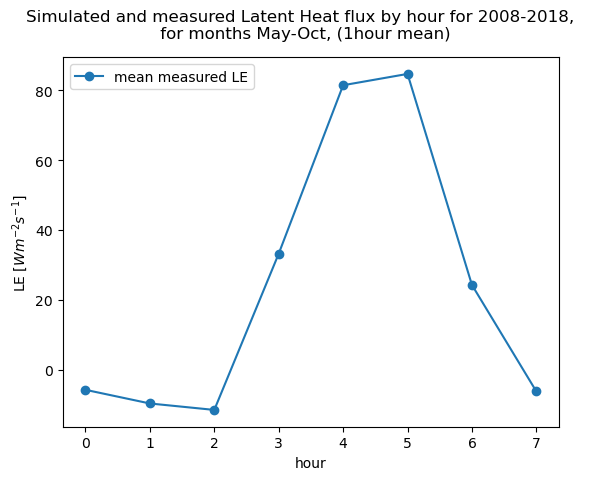

In [97]:
#draw binned LE
start='2008-04-01 00:00'
end='2018-08-30 00:00'

sim_data = df_ET.loc[start:end,('ET_VPD','last3day_prec')]
sim_data = sim_data.loc[(sim_data.index.month>=5) & (sim_data.index.month<=8)]
sim_data = sim_data.loc[sim_data['last3day_prec']==0.0]

sim_data=sim_data.resample('3H').mean()
sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
measured_data=df_Comb_filter.loc[start:end,'LE']#.resample('1H').mean()#.between_time("11:00", "18:00")
measured_data=measured_data.loc[measured_data>0]
measured_data=measured_data.resample('3H').mean()
measured_data=measured_data.dropna()

#df_tmp = pd.DataFrame()
df_tmp=pd.DataFrame(sim_data)
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)
df_tmp['ET_VPD-LE'] = df_tmp['ET_VPD']-df_tmp['LE']

hours_list=[0, 3, 6, 9, 12, 15, 18, 21]

d={}
d['meas_avg'] = [df_tmp.loc[df_tmp.index.hour==i,'LE'].mean() for i in hours_list]
d['meas_q1'] = [df_tmp.loc[df_tmp.index.hour==i,'LE'].quantile(q=0.25) for i in hours_list]
d['meas_q3'] = [df_tmp.loc[df_tmp.index.hour==i,'LE'].quantile(q=0.75) for i in hours_list]
d['diff_avg'] = [df_tmp.loc[df_tmp.index.hour==i,'ET_VPD-LE'].mean() for i in hours_list]

df_avg=pd.DataFrame(d)


fig,ax = plt.subplots()
p1=ax.plot(df_avg['diff_avg'],marker='o',label='mean measured LE')
#ax.fill_between(hours_list,df_avg['meas_q1'],df_avg['meas_q3'],alpha=0.1,label='IQR')

#ax.set_ylim(-5,40)
#ax.set_xlim(-5,40)
#plt.xticks(hours_list) 
ax.set_xlabel('hour')
ax.set_ylabel(r'LE [$Wm^{-2}s^{-1}$]')
fig.suptitle('Simulated and measured Latent Heat flux by hour for 2008-2018, \n for months May-Oct, (1hour mean)')
ax.legend(loc='upper left')


In [95]:
df_diff

,LE-ET_VPD,ET_VPD-LE
2008-05-05 12:00:00,-189.297957,189.297957
2008-05-05 15:00:00,-183.529586,183.529586
2008-05-05 18:00:00,-63.284990,63.284990
2008-05-05 21:00:00,-0.062689,0.062689
2008-05-06 00:00:00,-0.187174,0.187174
...,...,...
2017-08-27 09:00:00,-1.395425,1.395425
2017-08-27 12:00:00,-54.487186,54.487186
2017-08-27 15:00:00,-57.853398,57.853398
2017-08-27 18:00:00,-20.632476,20.632476


<Axes: >

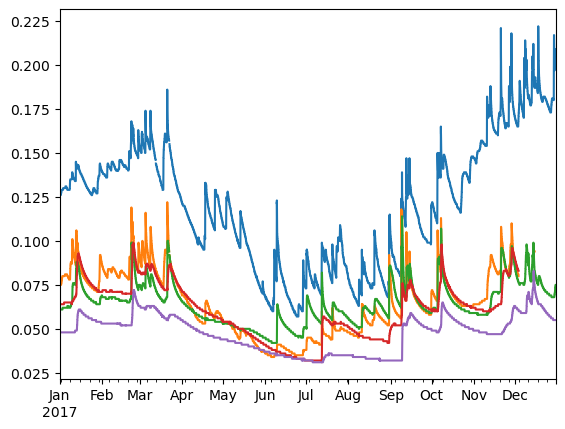

In [71]:
df_soil['SM-Lit'].loc['2017-01-01':'2017-12-30'].plot()
df_soil['SM-003'].loc['2017-01-01':'2017-12-30'].plot()
df_soil['SM-020'].loc['2017-01-01':'2017-12-30'].plot()
df_soil['SM-050'].loc['2017-01-01':'2017-12-30'].plot()
df_soil['SM-100'].loc['2017-01-01':'2017-12-30'].plot()

<Axes: >

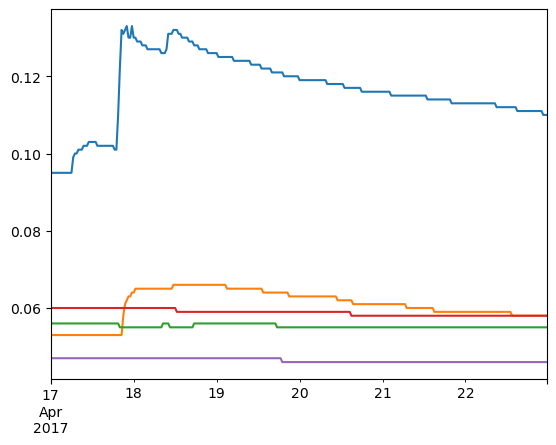

In [95]:
df_soil['SM-Lit'].loc['2017-04-17':'2017-04-22'].plot()
df_soil['SM-003'].loc['2017-04-17':'2017-04-22'].plot()
df_soil['SM-020'].loc['2017-04-17':'2017-04-22'].plot()
df_soil['SM-050'].loc['2017-04-17':'2017-04-22'].plot()
df_soil['SM-100'].loc['2017-04-17':'2017-04-22'].plot()

In [66]:
st='2015-04-01'
ed='2018-09-30'
#df_meteo.loc[st:ed,'L(o)corr'].loc[df_meteo['L(o)corr']>0].plot()
#df_meteo['L(o)corr'].loc[df_meteo['L(o)corr']>0].plot()

#df_meteo.loc[st:ed,'PAR'].plot()
#df_meteo['PAR'].plot()

#df_Comb.loc[st:ed,'VPD'].loc[df_Comb['VPD']>=0].plot()
#df_Comb['VPD'].loc[df_Comb['VPD']>=0].plot()

#df_profile.loc[st:ed,'CO2level1'].loc[df_profile['CO2level1']>=10].plot()
#df_meteo.columns

#df_Comb.loc[st:ed,'GPP_f'].loc[df_Comb['GPP_f']>=0].loc[df_Comb['GPP_f']<150].plot()
#df_Comb['GPP_f'].loc[df_Comb['GPP_f']>=0].loc[df_Comb['GPP_f']<150].plot()

#df_Comb.loc[st:ed,'LE'].loc[df_Comb['LE']>=0].plot()
#df_Comb['LE'].loc[df_Comb['LE']>=0].plot()


df_EC['U-star'].min()

-10000.0

<Axes: >

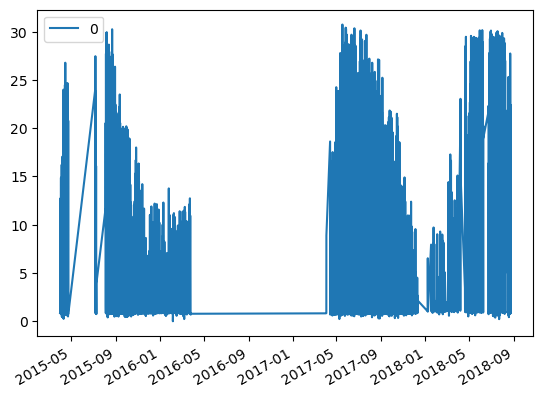

In [67]:
pd.DataFrame(an_umol).loc[st:ed].plot()

<Axes: >

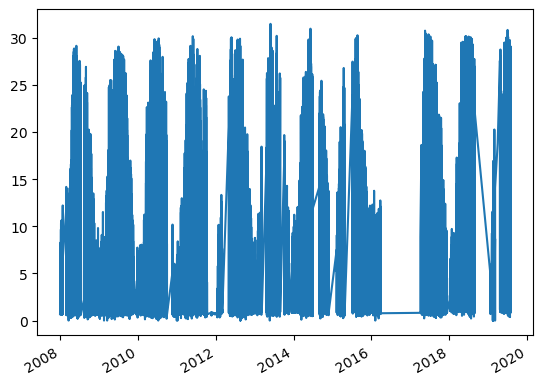

In [65]:
an_umol.plot()